#Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

import re
import csv
import string
import requests
from io import StringIO

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Data Loading

In [2]:
df = pd.read_csv('ulasan.csv')

In [3]:
df.head()

reviewId         userName  \
0  0a836e6b-6fc8-4646-841a-5dca21f158b5  Pengguna Google   
1  f1516667-f49f-4d30-8877-ca1cc906c28d  Pengguna Google   
2  217261dc-2f2b-4eb2-8258-2f4fe636063c  Pengguna Google   
3  2ccc6312-2603-4314-89df-8d548be8e423  Pengguna Google   
4  a554a7b8-e16e-4dc7-84fd-9014f75feb50  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  Perbaiki bug "freeze" (layar berhenti). Itu sa...      3            210   
1  bagus bgt game nya setiap hari aku mainin game...      1             14   
2  game ini seru, menarik,banyak game yang bisa d...      5           2447   
3  game nya jelek banget,banyak bug di mobile.ham...      1            139   
4  Gamenya sudah bagus. Tapi, mohon perbaiki bug-...      1              9   

  reviewCreatedVersion                   at  replyContent  repliedAt  \
0            2.666.609  2025-04-08 14:20:08           NaN        NaN   
1            2.667.668  2025-04-09 15:32:02           NaN        NaN   
2            2.666.609  2025-04-07 13:18:02           NaN        NaN   
3            2.666.609  2025-04-08 03:49:58           NaN        NaN   
4            2.667.668  2025-04-09 13:22:18           NaN        NaN   

  appVersion  
0  2.666.609  
1  2.667.668  
2  2.666.609  
3  2.666.609  
4  2.667.668

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              45000 non-null  object 
 1   userName              45000 non-null  object 
 2   userImage             45000 non-null  object 
 3   content               45000 non-null  object 
 4   score                 45000 non-null  int64  
 5   thumbsUpCount         45000 non-null  int64  
 6   reviewCreatedVersion  40726 non-null  object 
 7   at                    45000 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            40726 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.8+ MB


In [5]:
#Remove Missing Values
clean_df = df.dropna()

In [6]:
#Remove Duplicated Values
clean_df = df.drop_duplicates()

In [7]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              45000 non-null  object 
 1   userName              45000 non-null  object 
 2   userImage             45000 non-null  object 
 3   content               45000 non-null  object 
 4   score                 45000 non-null  int64  
 5   thumbsUpCount         45000 non-null  int64  
 6   reviewCreatedVersion  40726 non-null  object 
 7   at                    45000 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
 10  appVersion            40726 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.8+ MB


#Preprocessing Text

In [8]:
def cleaningText(text):
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'\d+\.\d+', '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", 'gk'])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [9]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}

def fix_slang(text):
  words = text.split()
  fixed_words = []

  for word in words:
    if word.lower() in slangwords:
      fixed_words.append(slangwords[word.lower()])
    else:
      fixed_words.append(word)

  fixed_text = ' '.join(fixed_words)

  return fixed_text

In [10]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

clean_df['text_casefolding'] = clean_df['text_clean'].apply(casefoldingText)

clean_df['text_slangwords'] = clean_df['text_casefolding'].apply(fix_slang)

clean_df['text_tokenize'] = clean_df['text_slangwords'].apply(tokenizingText)

clean_df['text_stopwords'] = clean_df['text_tokenize'].apply(filteringText)

clean_df['text_akhir'] = clean_df['text_stopwords'].apply(toSentence)

In [11]:
clean_df

reviewId         userName  \
0      0a836e6b-6fc8-4646-841a-5dca21f158b5  Pengguna Google   
1      f1516667-f49f-4d30-8877-ca1cc906c28d  Pengguna Google   
2      217261dc-2f2b-4eb2-8258-2f4fe636063c  Pengguna Google   
3      2ccc6312-2603-4314-89df-8d548be8e423  Pengguna Google   
4      a554a7b8-e16e-4dc7-84fd-9014f75feb50  Pengguna Google   
...                                     ...              ...   
44995  c4c35bf7-b080-43f2-ad33-842a62ac7503  Pengguna Google   
44996  4857590b-9d1d-4f2a-9abf-b442c8b1e50b  Pengguna Google   
44997  062e68b4-b340-4767-896e-c6b23d437a10  Pengguna Google   
44998  cd11f2f3-2a78-42f4-aa01-f1cfb19ee9a8  Pengguna Google   
44999  16e9c870-a1e2-4b56-a45e-f052fd2df660  Pengguna Google   

                                               userImage  \
0      https://play-lh.googleusercontent.com/EGemoI2N...   
1      https://play-lh.googleusercontent.com/EGemoI2N...   
2      https://play-lh.googleusercontent.com/EGemoI2N...   
3      https://play-lh.googleusercontent.com/EGemoI2N...   
4      https://play-lh.googleusercontent.com/EGemoI2N...   
...                                                  ...   
44995  https://play-lh.googleusercontent.com/EGemoI2N...   
44996  https://play-lh.googleusercontent.com/EGemoI2N...   
44997  https://play-lh.googleusercontent.com/EGemoI2N...   
44998  https://play-lh.googleusercontent.com/EGemoI2N...   
44999  https://play-lh.googleusercontent.com/EGemoI2N...   

                                                 content  score  \
0      Perbaiki bug "freeze" (layar berhenti). Itu sa...      3   
1      bagus bgt game nya setiap hari aku mainin game...      1   
2      game ini seru, menarik,banyak game yang bisa d...      5   
3      game nya jelek banget,banyak bug di mobile.ham...      1   
4      Gamenya sudah bagus. Tapi, mohon perbaiki bug-...      1   
...                                                  ...    ...   
44995  Ini seru. kita bisa berinteraksi dengan teman ...      5   
44996  Game nya bagus, tapi, pas Mao masuk game itu s...      4   
44997  Jadi game nya bagus bgt cuman banyak koneksi t...      4   
44998  Game nya bagus banyak map bisa mabar tapi kada...      5   
44999  Sebenerny game ny bgs sii,cmn ada beberapa bug...      4   

       thumbsUpCount reviewCreatedVersion                   at  replyContent  \
0                210            2.666.609  2025-04-08 14:20:08           NaN   
1                 14            2.667.668  2025-04-09 15:32:02           NaN   
2               2447            2.666.609  2025-04-07 13:18:02           NaN   
3                139            2.666.609  2025-04-08 03:49:58           NaN   
4                  9            2.667.668  2025-04-09 13:22:18           NaN   
...              ...                  ...                  ...           ...   
44995              0            2.661.713  2025-03-16 09:20:35           NaN   
44996              0                  NaN  2022-09-30 15:47:21           NaN   
44997              0                  NaN  2024-07-12 14:08:21           NaN   
44998             44            2.636.626  2024-08-04 08:35:07           NaN   
44999              0            2.532.470  2022-07-19 04:19:45           NaN   

       repliedAt appVersion  \
0            NaN  2.666.609   
1            NaN  2.667.668   
2            NaN  2.666.609   
3            NaN  2.666.609   
4            NaN  2.667.668   
...          ...        ...   
44995        NaN  2.661.713   
44996        NaN        NaN   
44997        NaN        NaN   
44998        NaN  2.636.626   
44999        NaN  2.532.470   

                                              text_clean  \
0      Perbaiki bug freeze layar berhenti Itu sangat ...   
1      bagus bgt game nya setiap hari aku mainin game...   
2      game ini seru menarikbanyak game yang bisa dim...   
3      game nya jelek bangetbanyak bug di mobilehampi...   
4      Gamenya sudah bagus Tapi mohon perbaiki bugbug...   
...                                           

#Labeling

In [12]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/positive.tsv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter='\t')

  next(reader)

  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

else:
  print('Failed to fetch data')

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/negative.tsv')

if response.status_code == 200:
  reader = csv.reader(StringIO(response.text), delimiter='\t')

  next(reader)

  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

else:
  print('Failed to fetch data')

In [13]:
def sentiment_analysis(text):

  score = 0

  for word in text:

    if word in lexicon_positive:
      score += lexicon_positive[word]

  for word in text:

    if word in lexicon_negative:
      score += lexicon_negative[word]

  polarity = ''

  if score > 0:
    polarity = 'positive'
  elif score < 0:
    polarity = 'negative'
  else:
    polarity = 'neutral'

  return score, polarity

In [14]:
results = clean_df['text_stopwords'].apply(sentiment_analysis)

results = list(zip(*results))

clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

print(clean_df['polarity'].value_counts())

polarity
positive    21360
negative    19302
neutral      4338
Name: count, dtype: int64


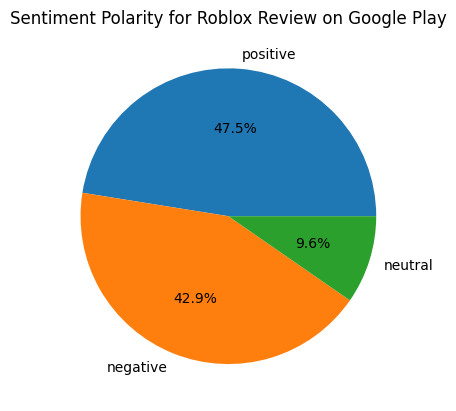

In [15]:
plt.pie(clean_df['polarity'].value_counts(), labels=clean_df['polarity'].value_counts().index, autopct='%1.1f%%')
plt.title('Sentiment Polarity for Roblox Review on Google Play')
plt.show()

In [16]:
text = ' '.join(clean_df['text_akhir'].astype(str).tolist())

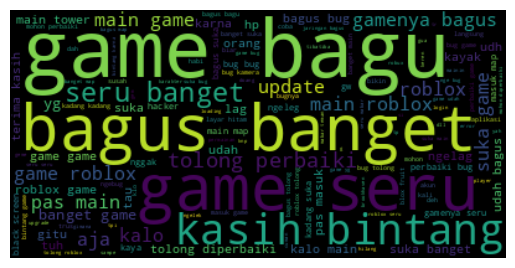

In [17]:
all = WordCloud().generate(text)
plt.imshow(all, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
positive_reviews = clean_df[clean_df['polarity'] == 'positive']
positive_text = ' '.join(positive_reviews['text_akhir'].astype(str).tolist())

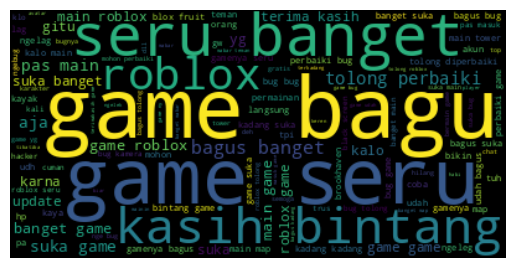

In [19]:
wordcloud_positive = WordCloud().generate(positive_text)

plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
negative_reviews = clean_df[clean_df['polarity'] == 'negative']
negative_text = ' '.join(negative_reviews['text_akhir'].astype(str).tolist())

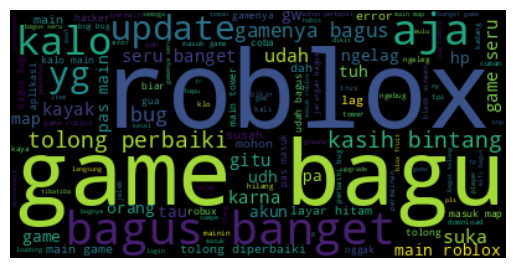

In [21]:
wordcloud_negative = WordCloud().generate(negative_text)

plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
neutral_reviews = clean_df[clean_df['polarity'] == 'neutral']
neutral_text = ' '.join(neutral_reviews['text_akhir'].astype(str).tolist())

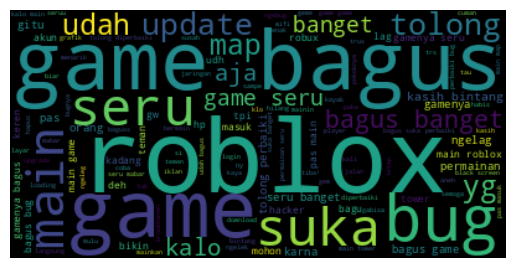

In [23]:
wordcloud_neutral = WordCloud().generate(neutral_text)

plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# Split Data

X = clean_df['text_akhir']
y = clean_df['polarity']

#Skema 1

In [25]:
# Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<oov>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=100)

y = pd.get_dummies(clean_df['polarity'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [27]:
# Model LSTM dan Embedding dengan pembagian data 80-20
model1 = Sequential([
    Embedding(input_dim=5000, output_dim=50),
    LSTM(128),
    Dense(3, activation='softmax'),
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.fit(X_train, y_train, epochs=10, batch_size=64, callbacks=[callbacks])

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6807 - loss: 0.7098
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8976 - loss: 0.2834
Epoch 3/10
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9265 - loss: 0.2088
Akurasi telah mencapai >92%!
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9265 - loss: 0.2088


In [28]:
train_loss, train_accuracy = model1.evaluate(X_train, y_train, batch_size=64)
test_loss, test_accuracy = model1.evaluate(X_test, y_test, batch_size=64)

563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9453 - loss: 0.1695
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9140 - loss: 0.2663


In [29]:
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Train Accuracy: 0.9429
Test Accuracy: 0.9119


#Skema 2

In [30]:
# Menggunakan Random Forest dan TF-IDF

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(clean_df['text_akhir'])

# Label Encoder

encoder = LabelEncoder()
y = encoder.fit_transform(clean_df['polarity'])

# Pembagian Data 80/20

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Model Random Forest

model2 = RandomForestClassifier(n_estimators=100, random_state=42)

model2.fit(X_train.toarray(), y_train)

y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'Train Accuracy: {acc_train:.4f}')
print(f'Test Accuracy: {acc_test:.4f}')

Train Accuracy: 0.9999
Test Accuracy: 0.8101


#Skema 3

In [31]:
# Menggunakan Naive Bayes dan Bag of Words

bow = CountVectorizer(max_features=5000)
X_bow = bow.fit_transform(clean_df['text_akhir'])

# Label Encoder
le = LabelEncoder()
y = le.fit_transform(clean_df['polarity'])

#Pembagian Data 70/30

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.3, random_state=42)

# Model Naive Bayes

model3 = BernoulliNB()

model3.fit(X_train, y_train)

y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'Train Accuracy: {acc_train:.4f}')
print(f'Test Accuracy: {acc_test:.4f}')

Train Accuracy: 0.7423
Test Accuracy: 0.7104


# Kesimpulan

Dari data di atas bisa kita lihat kalau model yang bekerja paling baik adalah model LSTM kemudian RandomForestClassifier, dan NaiveBayes di peringkat terakhir

#Inference

In [32]:
# Input Kalimat
kalimat = [
    'game ini sangat bagus',
    'tolong update gamenya',
    'gamenya jelek',
]

In [33]:
tes_feature = tokenizer.texts_to_sequences(kalimat)
pad = pad_sequences(tes_feature, maxlen=100)

# Predict
predictions = model1.predict(pad)

label = ['negative', 'positive', 'neutral']
predicted_labels = np.argmax(predictions, axis=1)

for pred in predicted_labels:
  print(label[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
positive
neutral
negative


In [ ]:
# Export Model

import joblib

model1.save('lstm_model.h5')
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']